adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from colorclade import draw_colorclade_tree
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm

from pylib._build_hstrat_surfaces import build_hstrat_surfaces
from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._hstrat_reconstruct_dataframe import (
    hstrat_reconstruct_dataframe,
)
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_hstrat_surface_dataframe import (
    make_hstrat_surface_dataframe,
)
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._transform_box_max import TransformBoxMax
from pylib.difflenia._AttributeBoxMax import AttributeBoxMax
from pylib.difflenia._VideoWriter import VideoWriter
from pylib.difflenia._generate_observations import generate_observations

torch.set_default_tensor_type("torch.FloatTensor")
make_reproducible()


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-25T01:31:58.993549+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

matplotlib: 3.9.2
torch     : 2.0.1

Watermark: 2.4.3



In [4]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O '/tmp/crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O '/tmp/crea2.pickle'
!wget  'https://osf.io/ba536/download' -O '/tmp/crea3.pickle'


--2025-03-25 01:31:59--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-25 01:31:59--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘/tmp/crea1.pickle’

/tmp/crea1.pickle   100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-25 01:32:00 (113 MB/s) - ‘/tmp/crea1.pickle’ saved [12214/12214]

--2025-03-25 01:32:00--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190.

In [5]:
image_counter = it.count()
image_subdir = "dev-difflenia-TransformBoxMax"
os.makedirs(image_subdir, exist_ok=True)


def make_gif_path():
    return f"{image_subdir}/image_{next(image_counter):04d}.gif"


In [6]:
def show_sample_observations(
    SX,
    SY,
    *,
    borders,
    device,
    mode,
    num_frames,
    crea_file="crea1.pickle",
    every_nth=5,
    fps=30.0,
    logger=print,
    zoom=1,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        borders=borders,
        crea_file=crea_file,
        device=device,
        mode=mode,
        num_frames=num_frames,
        zoom=zoom,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [7]:
def show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    *,
    dstream_algo,
    dstream_S,
    logger,
    num_frames,
    surface_transform,
):
    with log_context_duration("build_hstrat_surfaces", logger=logger):
        surfaces = build_hstrat_surfaces(
            [state[:, :, 0].numpy() for state in obvs.states],
            (SY, SX),
            dstream_algo=dstream_algo,
            dstream_S=dstream_S,
            surface_transform=surface_transform,
        )
    with log_context_duration("make_hstrat_surface_dataframe", logger=logger):
        surfaces_df = make_hstrat_surface_dataframe(
            surfaces[-1],
            num_frames + dstream_S,
            values=obvs.states[-1][:, :, 0].numpy(),
            dstream_algo=dstream_algo,
        )
    with log_context_duration("hstrat_reconstruct_dataframe", logger=logger):
        surfaces_phylo = hstrat_reconstruct_dataframe(
            surfaces_df[surfaces_df["value"] > 0.2],
        )
    surfaces_phylo["ancestor_list"] = [
        "[]" if id_ == ancestor_id else f"[{ancestor_id}]"
        for (id_, ancestor_id) in zip(
            surfaces_phylo["id"],
            surfaces_phylo["ancestor_id"],
        )
    ]
    with log_context_duration("draw_colorclade_tree", logger=logger):
        draw_colorclade_tree(
            surfaces_phylo,
            backend="biopython",
            label_tips=False,
            taxon_name_key="id",
        )
    plt.show()


In [8]:
SX, SY = 448, 448
borders = True
box_size = 7
device = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
dstream_algo = "dstream.tilted_algo"
logger = print
mode = "random"
num_frames = 1000
dstream_S = 64
surface_transform = TransformBoxMax(box_size)


In [9]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:126: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.789339542388916}
enter log_context_duration for Creating video


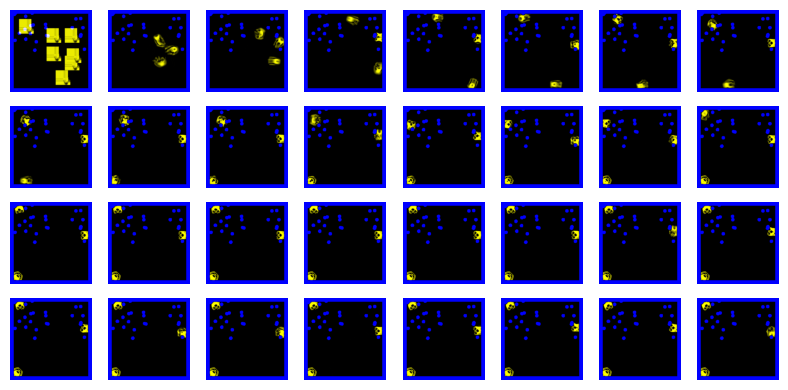

exit log_context_duration for Creating video
!!! {"Creating video": 5.793365716934204}
enter log_context_duration for Creating reversed video


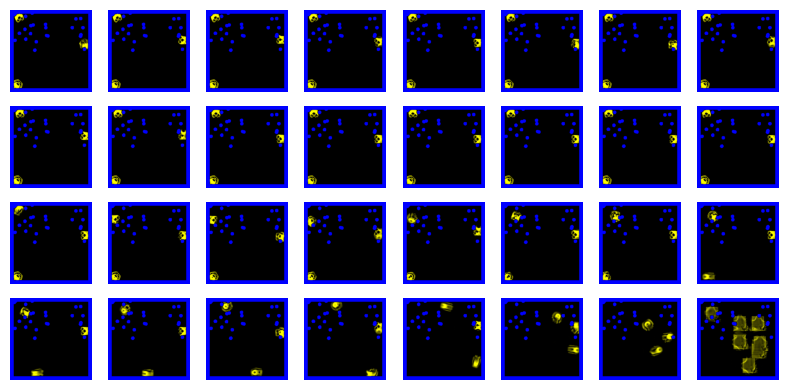

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.87468147277832}


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


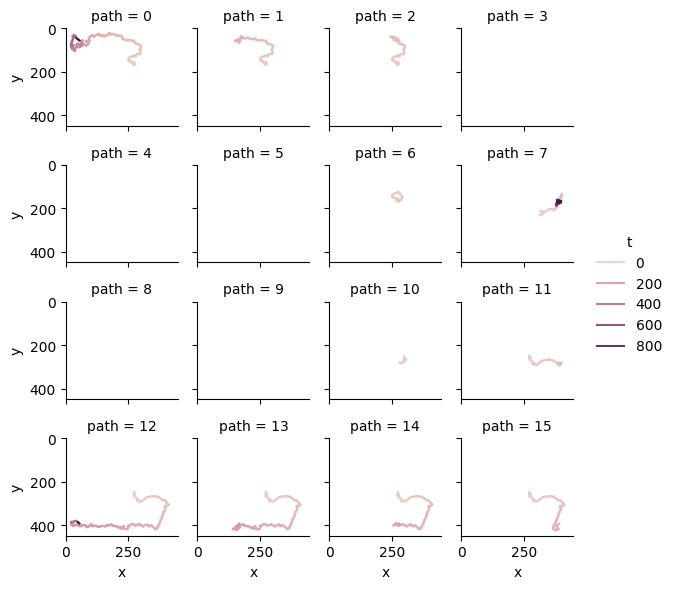

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.37006378173828}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1579897403717041}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 165.0507779121399}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 8.693183660507202}


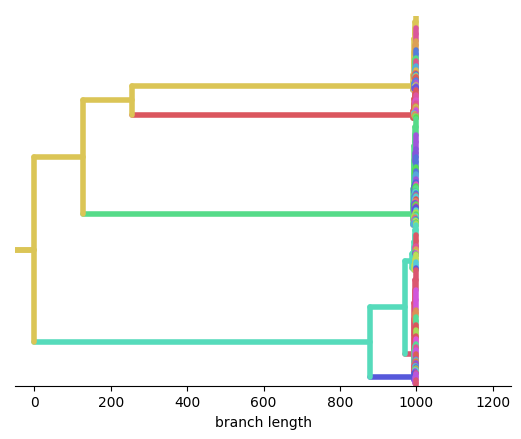

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.130280017852783}
enter log_context_duration for Creating video


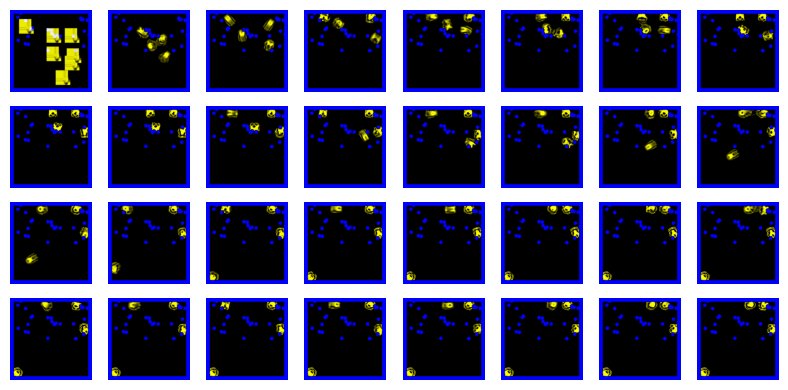

exit log_context_duration for Creating video
!!! {"Creating video": 5.8796069622039795}
enter log_context_duration for Creating reversed video


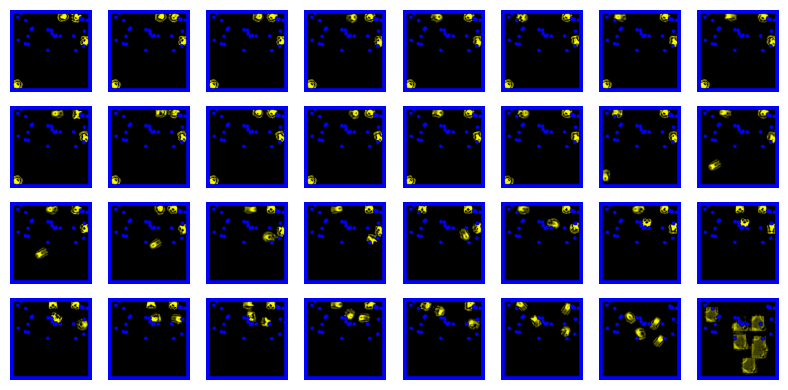

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.3753578662872314}


100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


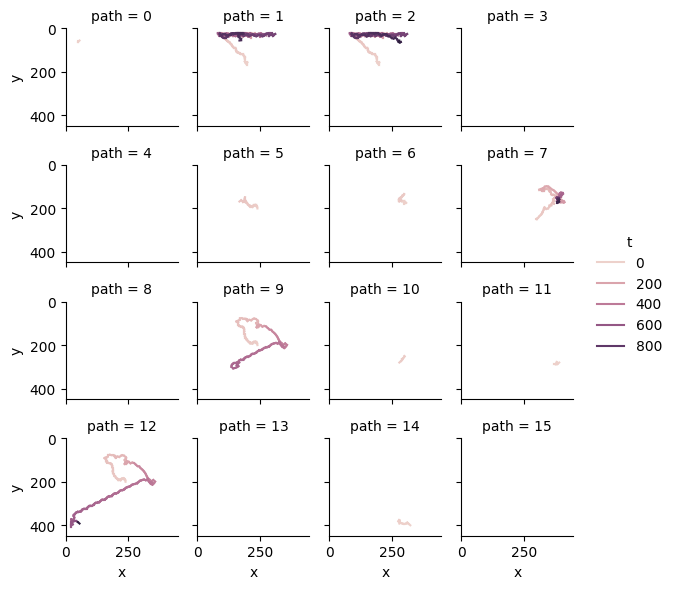

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.64176940917969}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15684175491333008}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.583511352539062}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 12.812815427780151}


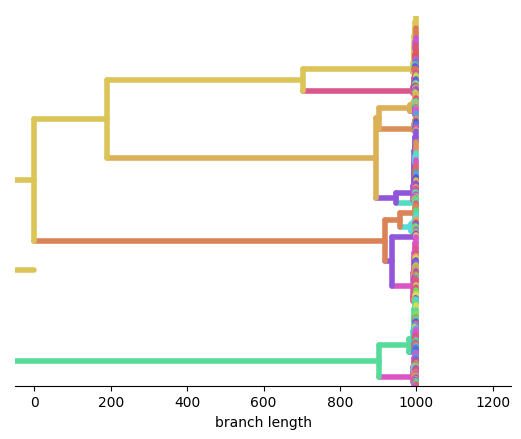

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 22.67410445213318}
enter log_context_duration for Creating video


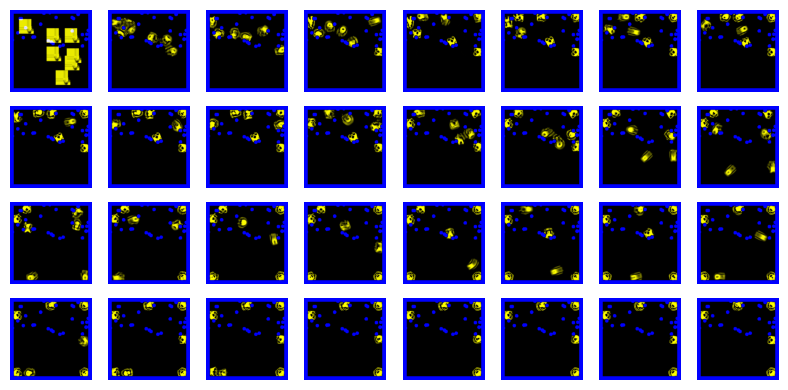

exit log_context_duration for Creating video
!!! {"Creating video": 5.742102861404419}
enter log_context_duration for Creating reversed video


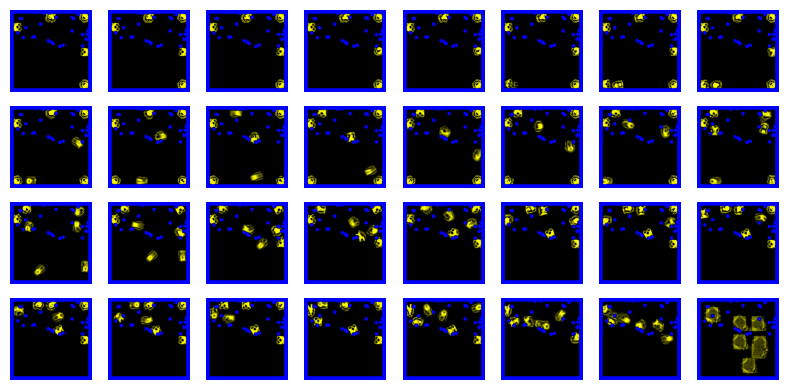

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.813278675079346}


100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


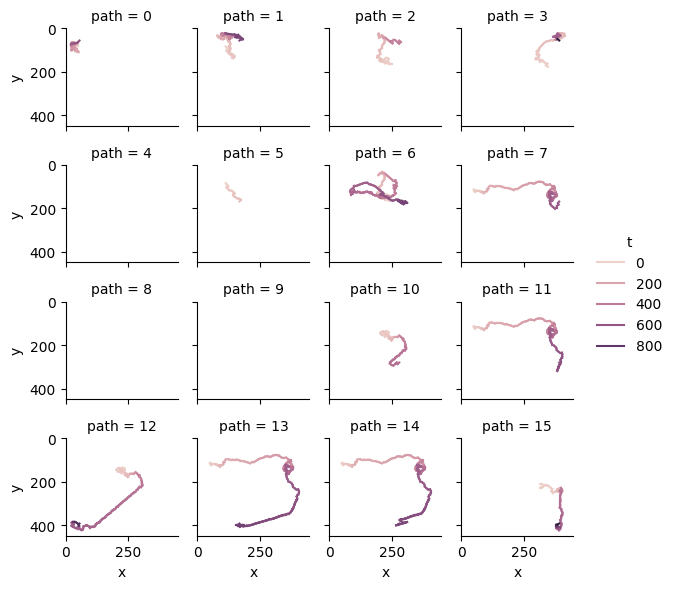

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.62131476402283}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15172481536865234}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.62467670440674}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 15.027247667312622}


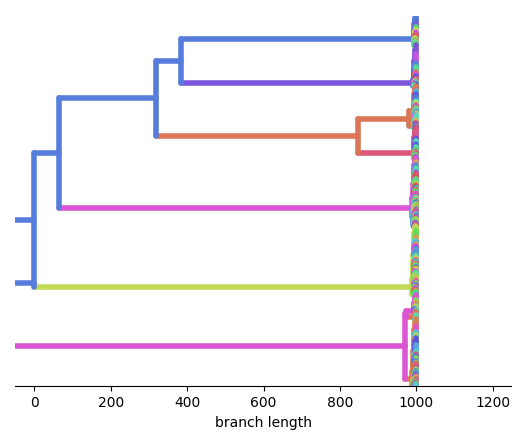

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.755948543548584}
enter log_context_duration for Creating video


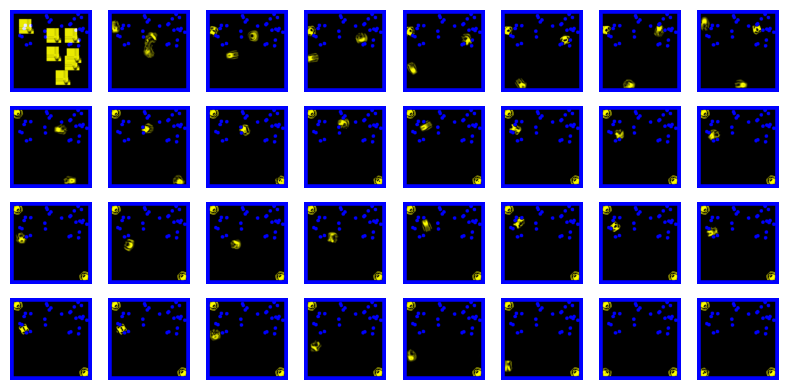

exit log_context_duration for Creating video
!!! {"Creating video": 5.687711715698242}
enter log_context_duration for Creating reversed video


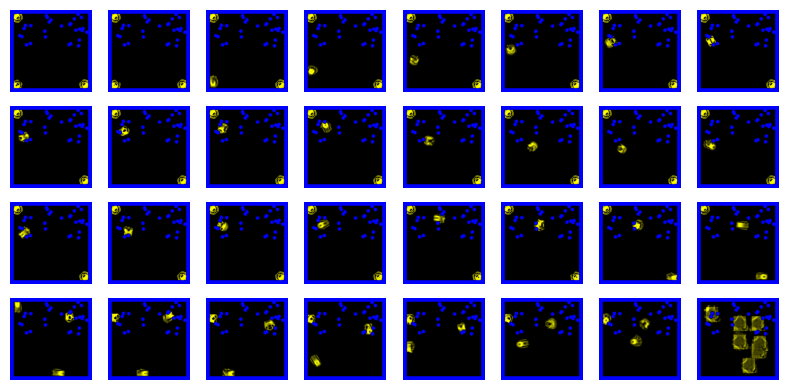

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.682771921157837}


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


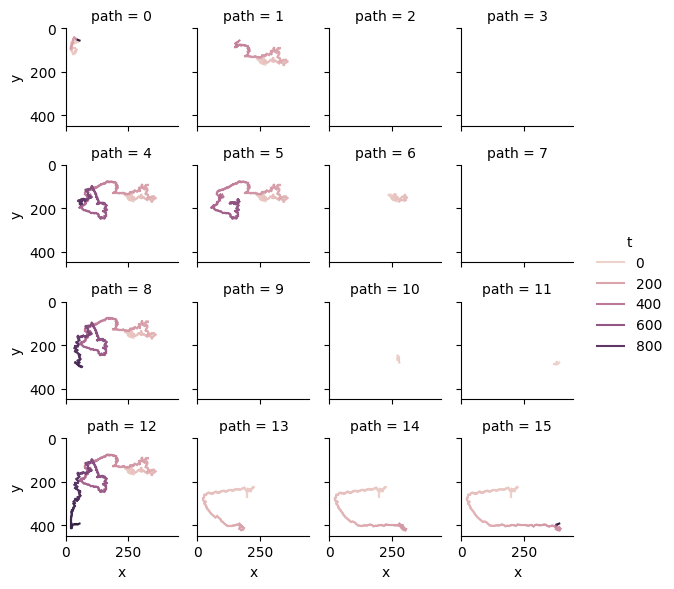

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.026081562042236}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.14995265007019043}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.18740439414978}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 9.288385152816772}


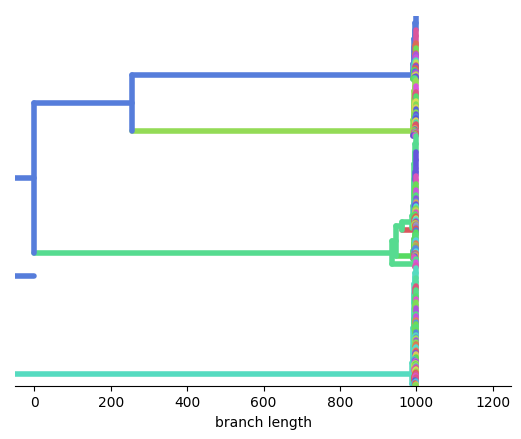

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 22.202547073364258}
enter log_context_duration for Creating video


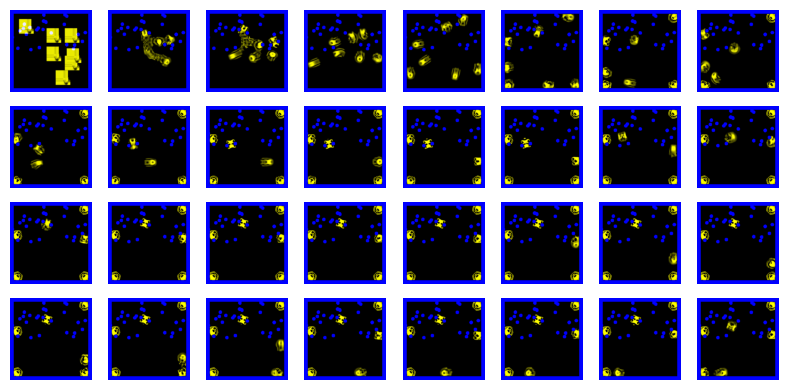

exit log_context_duration for Creating video
!!! {"Creating video": 5.827123403549194}
enter log_context_duration for Creating reversed video


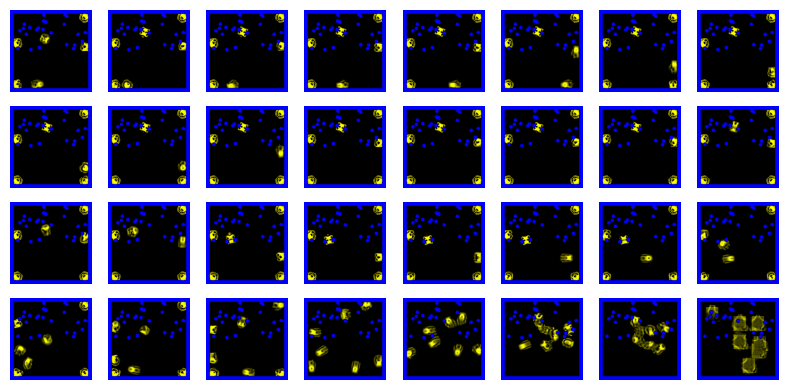

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.880036115646362}


100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


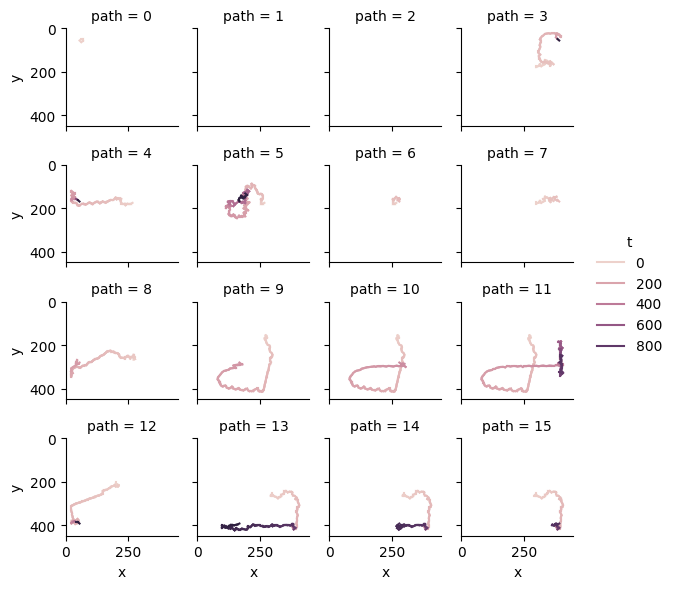

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.92017483711243}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1534285545349121}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.53790521621704}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 20.311126947402954}


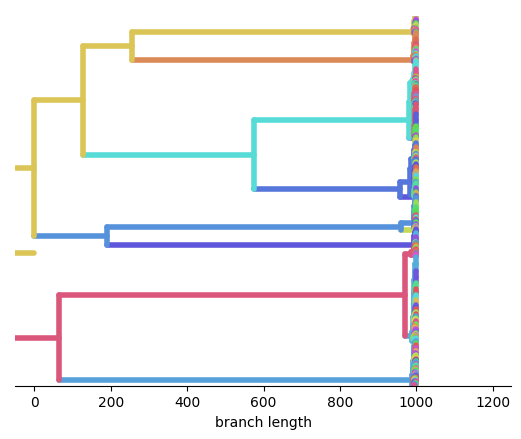

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.64810800552368}
enter log_context_duration for Creating video


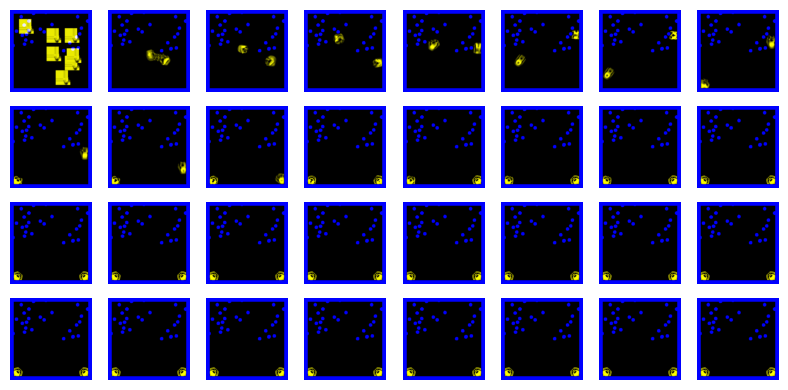

exit log_context_duration for Creating video
!!! {"Creating video": 4.485585927963257}
enter log_context_duration for Creating reversed video


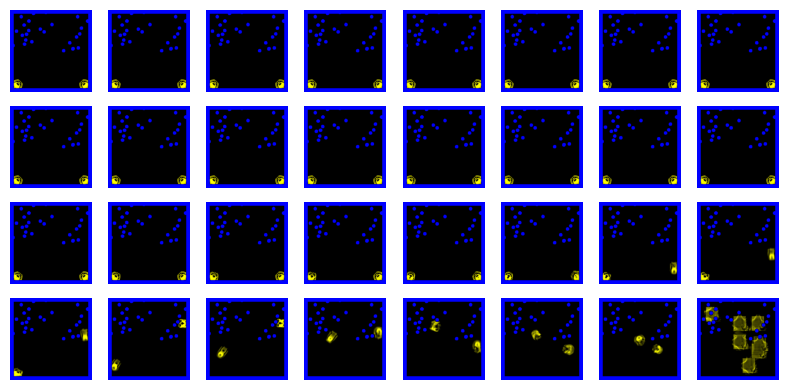

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.531327247619629}


100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


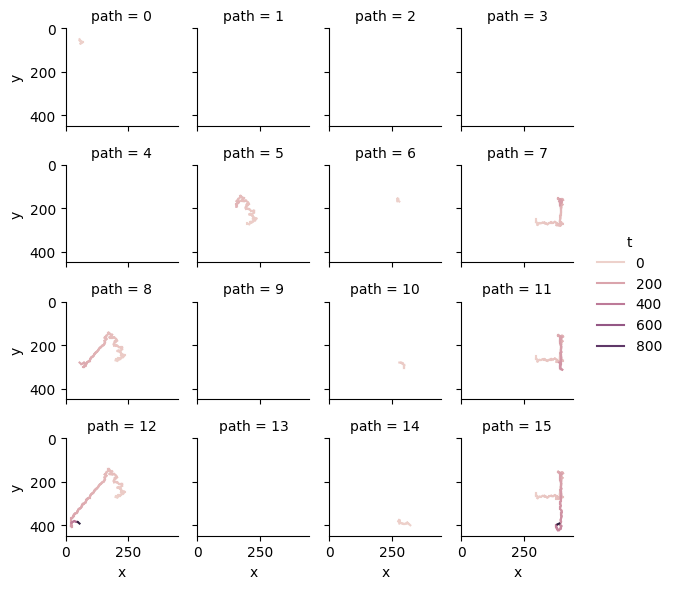

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.50498151779175}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15033221244812012}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.565242290496826}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 5.469844102859497}


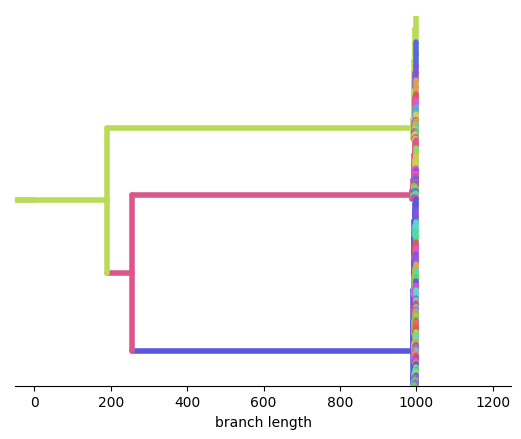

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.063175678253174}
enter log_context_duration for Creating video


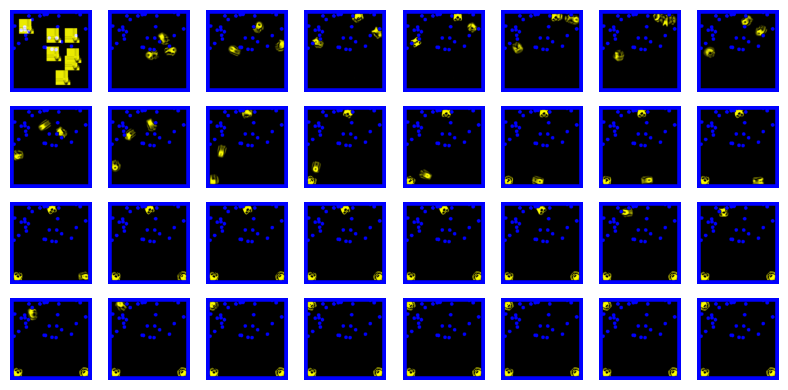

exit log_context_duration for Creating video
!!! {"Creating video": 5.4738383293151855}
enter log_context_duration for Creating reversed video


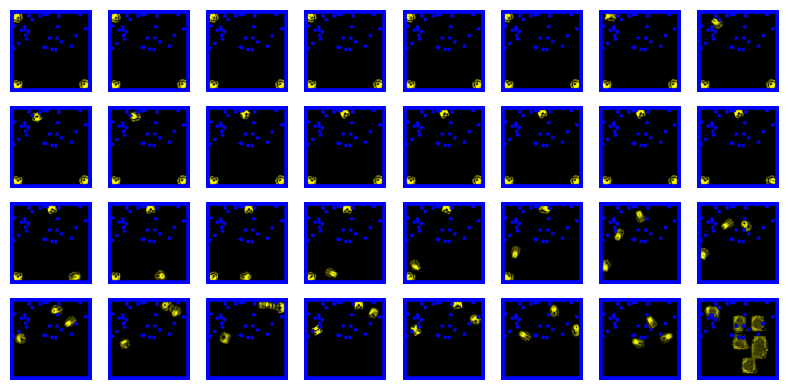

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.4905476570129395}


100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


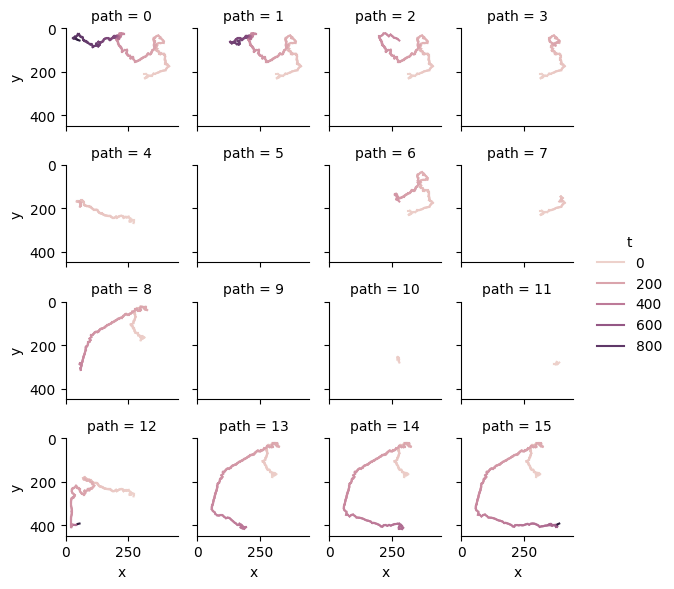

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.88971304893494}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15383458137512207}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.672033309936523}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 7.291292190551758}


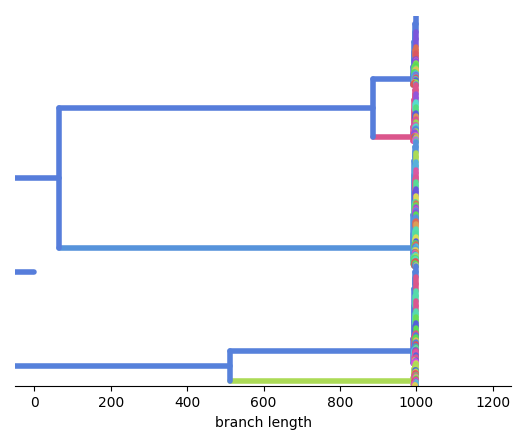

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 23.360006093978882}
enter log_context_duration for Creating video


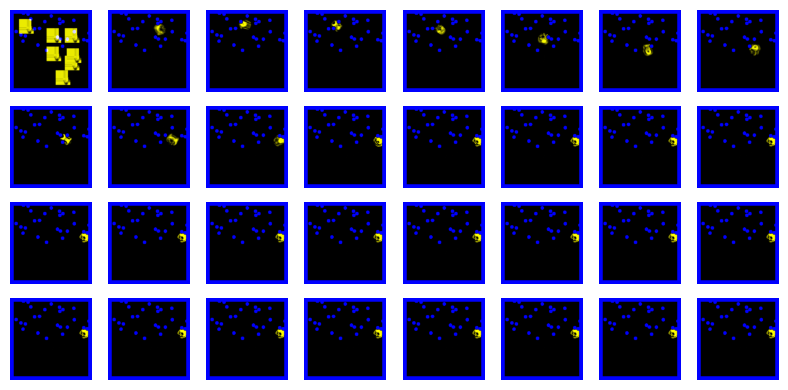

exit log_context_duration for Creating video
!!! {"Creating video": 6.338402986526489}
enter log_context_duration for Creating reversed video


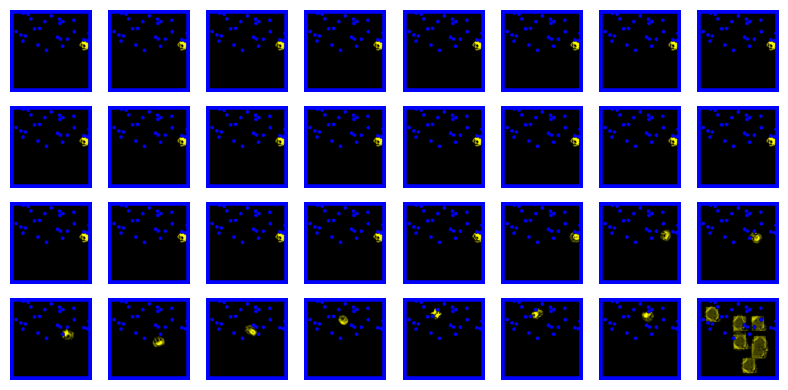

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.244290113449097}


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


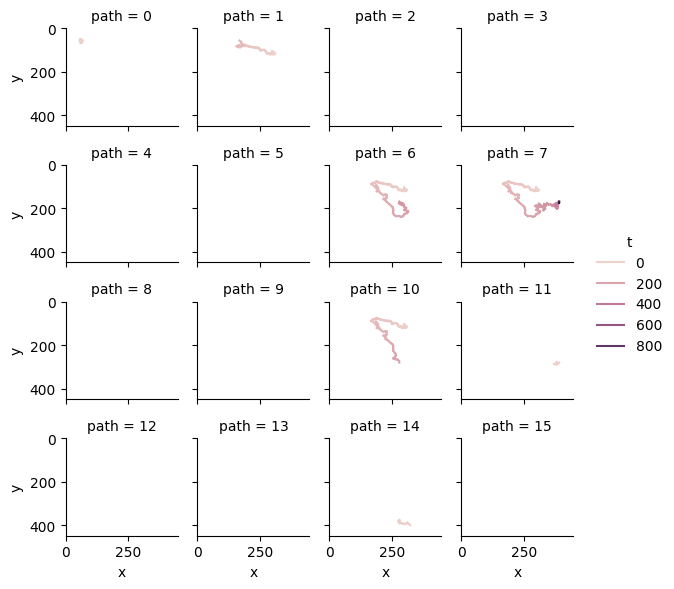

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.561492919921875}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.1526045799255371}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 22.680802583694458}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 3.093386173248291}


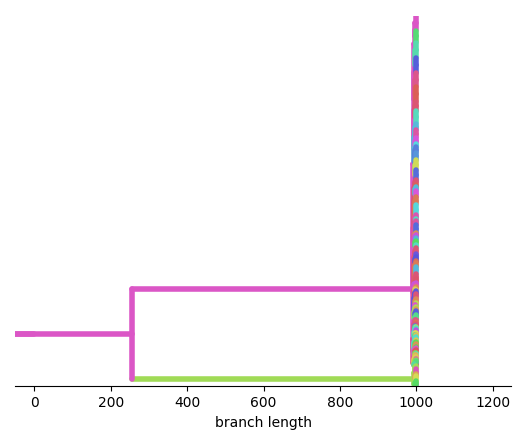

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.56535530090332}
enter log_context_duration for Creating video


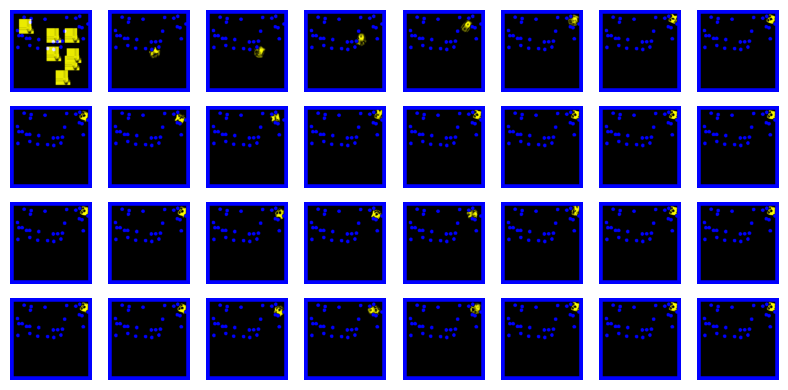

exit log_context_duration for Creating video
!!! {"Creating video": 4.4214863777160645}
enter log_context_duration for Creating reversed video


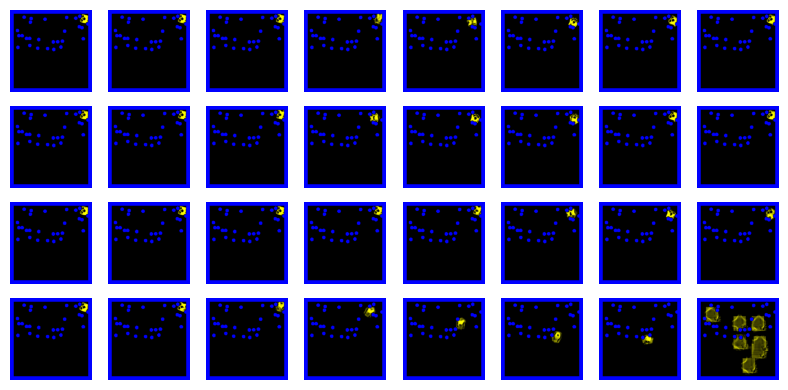

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 4.39682674407959}


100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


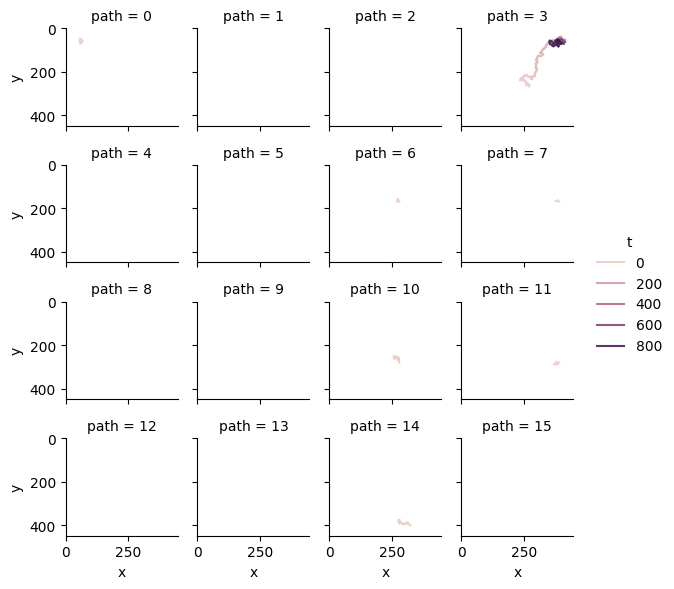

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 51.97602319717407}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15378117561340332}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.569307327270508}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 3.070565938949585}


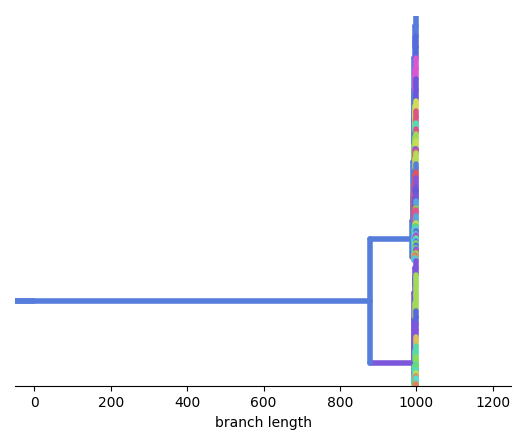

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 22.0396888256073}
enter log_context_duration for Creating video


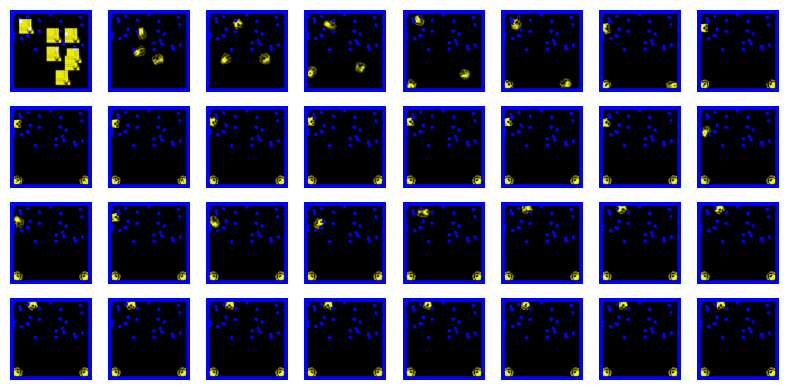

exit log_context_duration for Creating video
!!! {"Creating video": 5.667253255844116}
enter log_context_duration for Creating reversed video


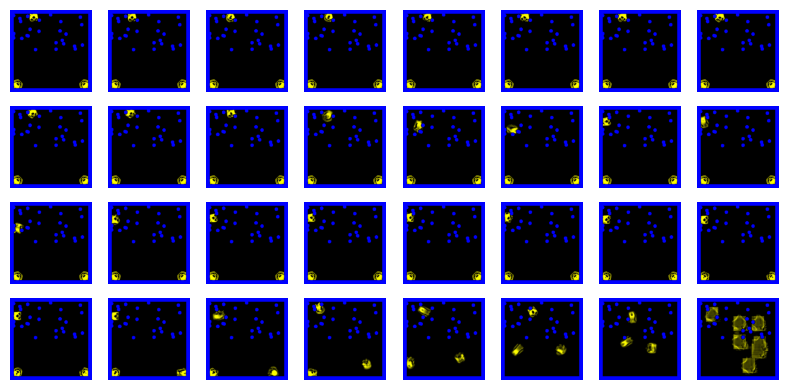

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.6600587368011475}


100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


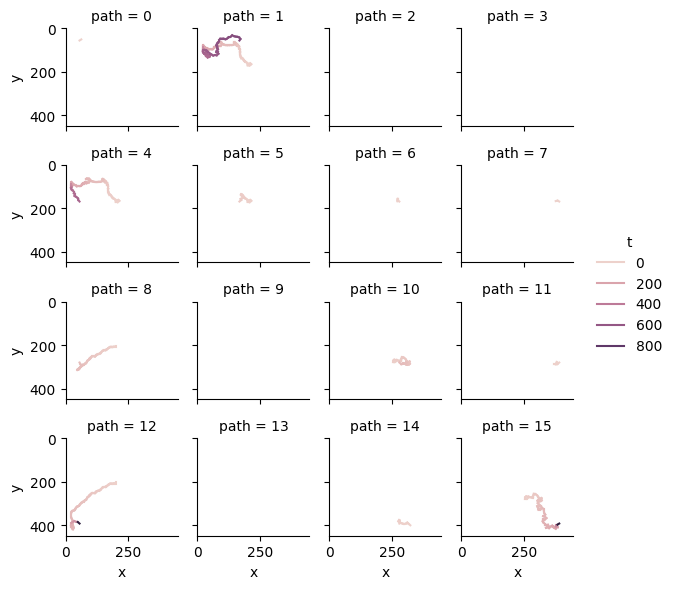

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.61832094192505}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15096473693847656}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.72001361846924}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 7.233013868331909}


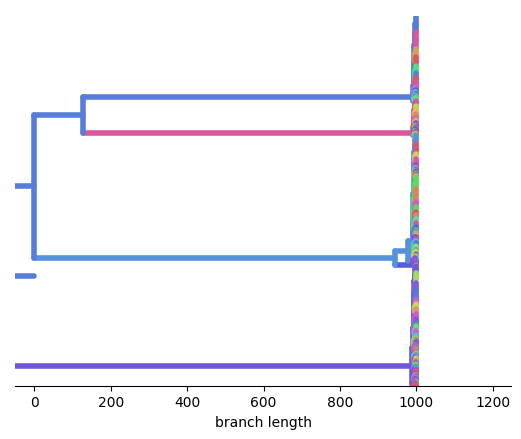

In [10]:
for i in range(10):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea1.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.74544930458069}
enter log_context_duration for Creating video


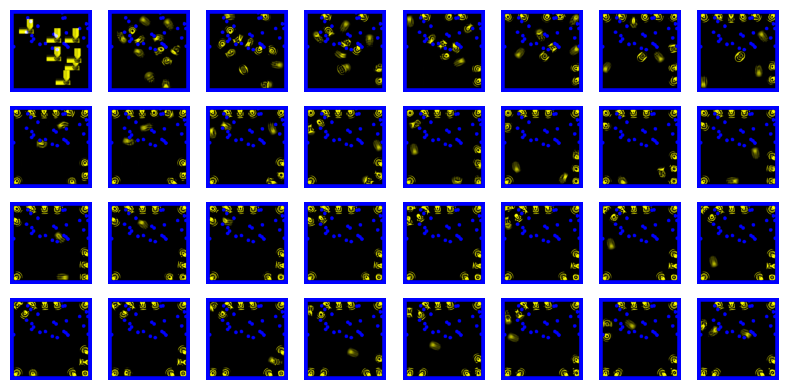

exit log_context_duration for Creating video
!!! {"Creating video": 8.25131106376648}
enter log_context_duration for Creating reversed video


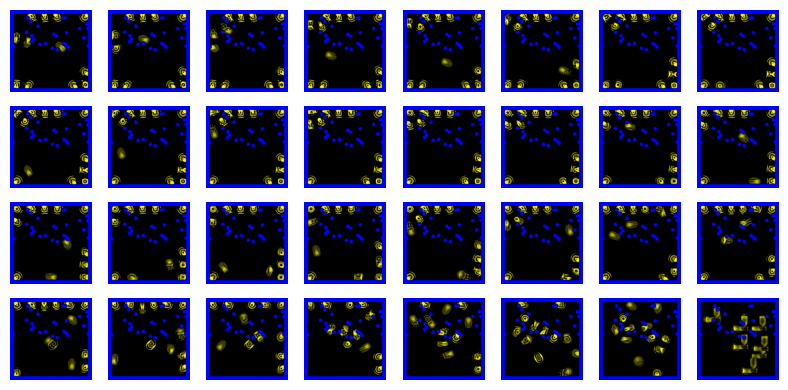

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.099449872970581}


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


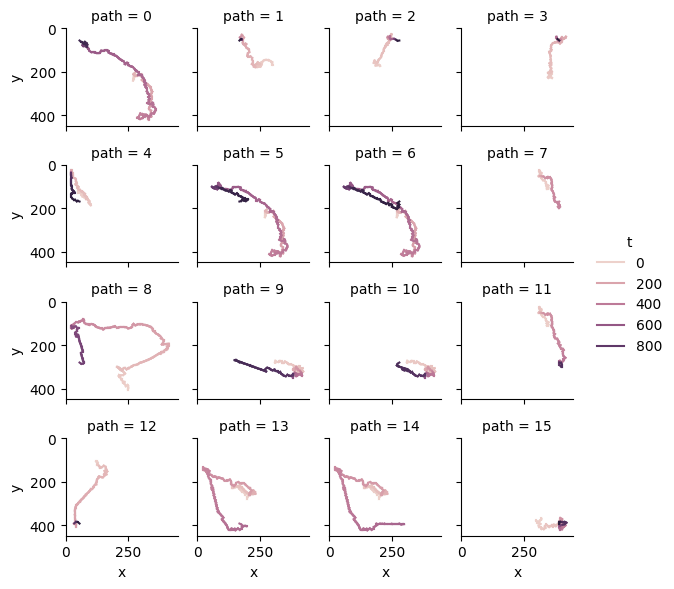

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 52.82179880142212}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15107035636901855}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.421733379364014}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 24.752505779266357}


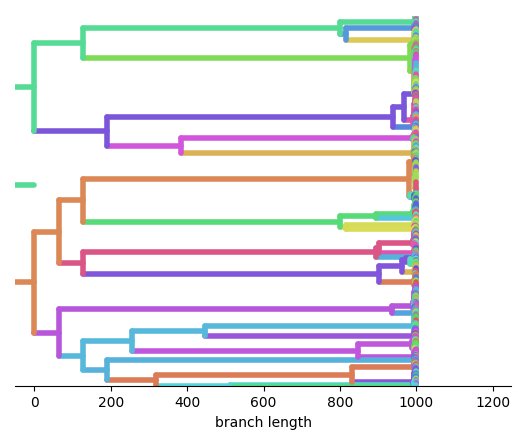

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 19.666991472244263}
enter log_context_duration for Creating video


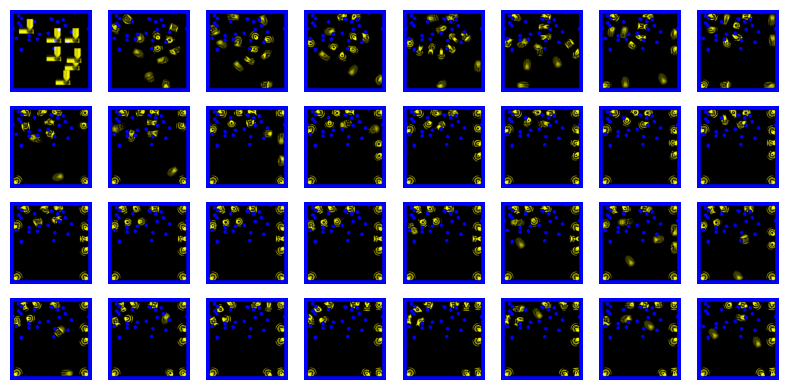

exit log_context_duration for Creating video
!!! {"Creating video": 6.160790681838989}
enter log_context_duration for Creating reversed video


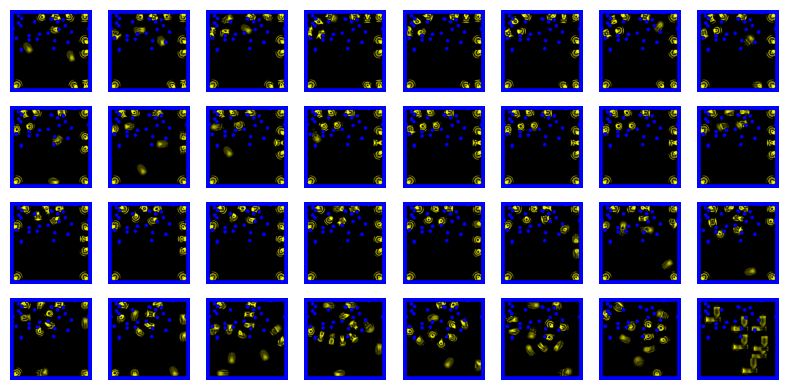

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 6.134077310562134}


100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


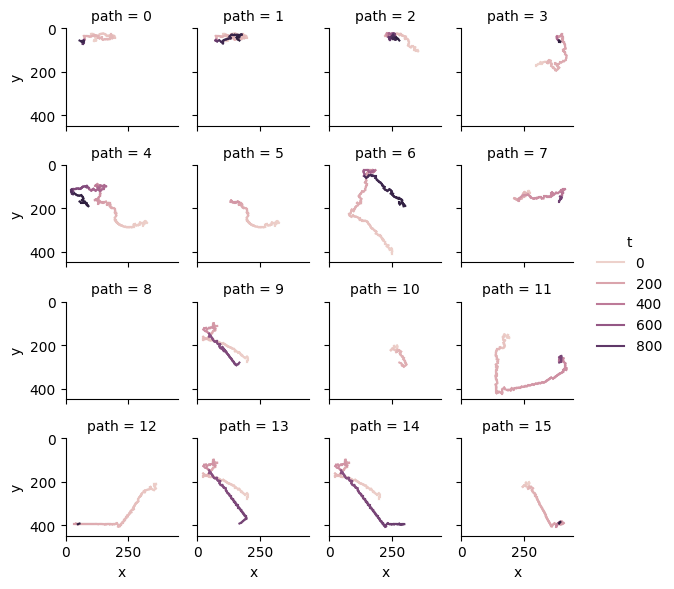

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 54.66083908081055}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.15213513374328613}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 23.078308582305908}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 27.080639839172363}


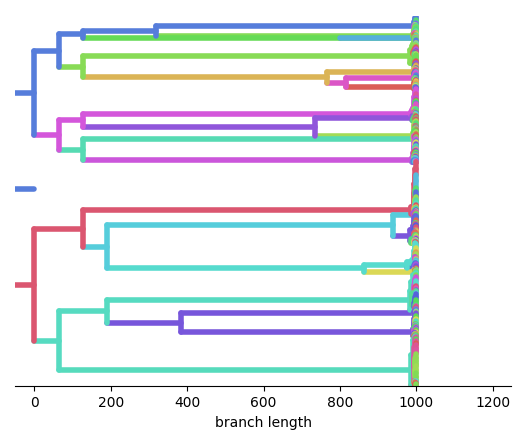

In [11]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea2.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )
